In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import RobertaModel, ViTModel
from transformers import RobertaTokenizer, ViTFeatureExtractor
from sklearn.decomposition import PCA
import plotly.express as px

warnings.simplefilter("ignore", category=UserWarning)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_STATE = 8

c:\Users\braes\miniconda3\envs\models\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load data from each annotator

In [ ]:
combined_df = pd.read_json('dataset.csv')

In [ ]:
# my labels
annotator1_labels = combined_df['label']

In [ ]:
# khaled labels
annotator2_json = pd.read_json('annotator2.json')
annotator2_labels = annotator2_json['image_classes']

In [ ]:
# stratos labels
annotator3_json = pd.read_json('stratos.json')
annotator3_json = annotator3_json[annotator3_json['annotator'] == 2].reset_index(drop=True)
annotator3_labels = annotator3_json['image_classes']

In [ ]:
print(combined_df['text'][:3])
print(annotator2_json['text'][:3])
print(annotator3_json['text'][:3])
print(len(combined_df))
print(len(annotator2_json))
print(len(annotator3_json))

0    Oh hey, Alberta has seen 1,400,021 hectares bu...
1    West Kiskatinaw River wildfire near Tumbler Ri...
2    Members of the Vavenby Fire Department in Elec...
Name: text, dtype: object
0    Oh hey, Alberta has seen 1,400,021 hectares bu...
1    West Kiskatinaw River wildfire near Tumbler Ri...
2    Members of the Vavenby Fire Department in Elec...
Name: text, dtype: object
0    Oh hey, Alberta has seen 1,400,021 hectares bu...
1    West Kiskatinaw River wildfire near Tumbler Ri...
2    Members of the Vavenby Fire Department in Elec...
Name: text, dtype: object
4688
4688
4688


# check for missing annotations

In [ ]:
annotator2_json[annotator2_json['image_classes'].isna()]

,tweet_id,img_id,posted_at,username,author_location,text,image,country_code,country,full_name,...,author_name,media_keys,id,image_classes,annotator,annotation_id,created_at,updated_at,lead_time,contains_personal_info


In [ ]:
annotator3_json[annotator3_json['image_classes'].isna()]

,tweet_id,img_id,posted_at,username,author_location,text,image,country_code,country,full_name,...,author_name,media_keys,id,image_classes,annotator,annotation_id,created_at,updated_at,lead_time,contains_personal_info


# check agreement

In [ ]:
# how often two agree but one disagrees, using mode:
from collections import Counter
import numpy as np

# Ensure labels are lists or arrays of equal length
labels1 = list(annotator1_labels)
labels2 = list(annotator2_labels)
labels3 = list(annotator3_labels)

majority_vote = []
majority_agreement = []
full_agreement = []

for a, b, c in zip(labels1, labels2, labels3):
    label_set = [a, b, c]
    count = Counter(label_set)
    most_common_label, freq = count.most_common(1)[0]
    
    majority_vote.append(most_common_label)
    majority_agreement.append(freq >= 2)
    full_agreement.append(freq == 3)

# Compute agreement stats
majority_agreement_rate = np.mean(majority_agreement)
full_agreement_rate = np.mean(full_agreement)
no_agreement_rate = 1 - np.mean([len(set(x)) < 3 for x in zip(labels1, labels2, labels3)])

print(f"Majority agreement rate (at least 2 same):   {majority_agreement_rate*100:.2f}%")
print(f"Full agreement rate (all 3 same):            {full_agreement_rate*100:.2f}%")
print(f"No agreement (all 3 different):              {no_agreement_rate*100:.2f}%")

Majority agreement rate (at least 2 same):   88.40%
Full agreement rate (all 3 same):            45.12%
No agreement (all 3 different):              11.60%


In [31]:
# cohens kappa
from sklearn.metrics import cohen_kappa_score

kappa_1_2 = cohen_kappa_score(labels1, labels2)
kappa_1_3 = cohen_kappa_score(labels1, labels3)
kappa_2_3 = cohen_kappa_score(labels2, labels3)

print(f"Cohen's Kappa between annotator 1-2: {kappa_1_2:.3f}")
print(f"Cohen's Kappa between annotator 1-3: {kappa_1_3:.3f}")
print(f"Cohen's Kappa between annotator 2-3: {kappa_2_3:.3f}")

Cohen's Kappa between annotator 1-2: 0.635
Cohen's Kappa between annotator 1-3: 0.506
Cohen's Kappa between annotator 2-3: 0.492


In [32]:
# Fleiss' Kappa
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa

# Suppose you have 3 annotators:
annotators = [labels1, labels2, labels3]  # Each is a list of length N

# Step 1: Get all unique class labels across all annotators
all_labels = sorted(set(label for rater in annotators for label in rater))

# Step 2: Create mapping from class label to index
label_to_index = {label: i for i, label in enumerate(all_labels)}
n_categories = len(label_to_index)
n_items = len(annotators[0])

# Step 3: Initialize rating matrix (N_items × N_categories)
rating_matrix = np.zeros((n_items, n_categories), dtype=int)

# Step 4: Populate matrix: count how many annotators gave each class to each item
for i in range(n_items):
    for rater in annotators:
        class_index = label_to_index[rater[i]]
        rating_matrix[i, class_index] += 1

# Step 5: Compute Fleiss’ Kappa
fkappa = fleiss_kappa(rating_matrix)
print(f"Fleiss' Kappa: {fkappa:.3f}")

Fleiss' Kappa: 0.543


In [34]:
# krippendorff's alpha
import krippendorff
import numpy as np

# Assume: labels1, labels2, labels3 are lists of equal length
annotators = [labels1, labels2, labels3]

# Convert class labels to integers (if needed)
all_labels = sorted(set(label for r in annotators for label in r))
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Convert to numerical format
numeric_annotators = [
    [label_to_index[label] for label in rater]
    for rater in annotators
]

# Transpose to shape (N_items x N_annotators)
data_matrix = np.array(numeric_annotators).T

# Compute Krippendorff’s alpha (nominal metric for categories)
alpha = krippendorff.alpha(reliability_data=data_matrix, level_of_measurement='nominal')
print(f"Krippendorff's Alpha (nominal): {alpha:.3f}")

Krippendorff's Alpha (nominal): 0.004


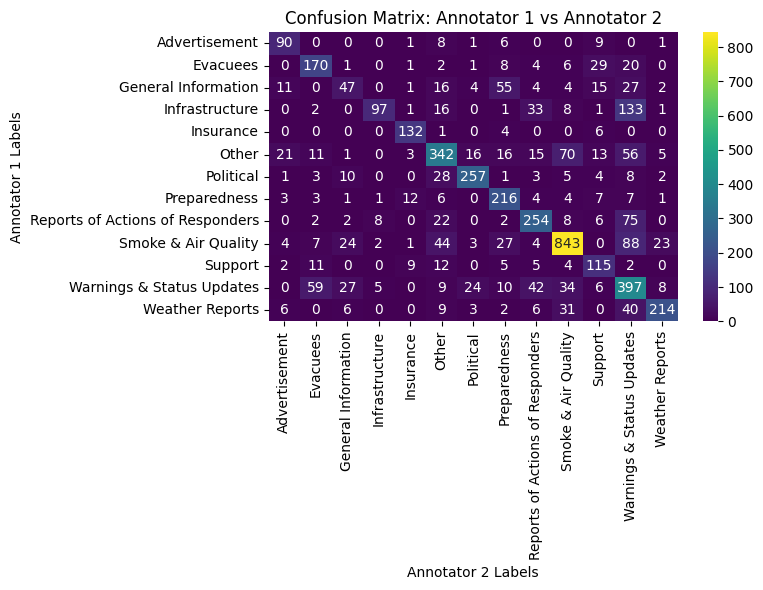

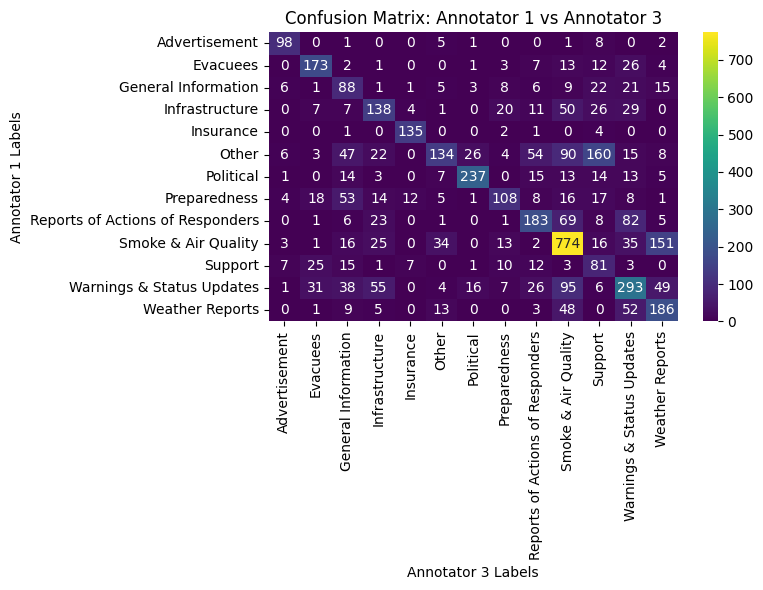

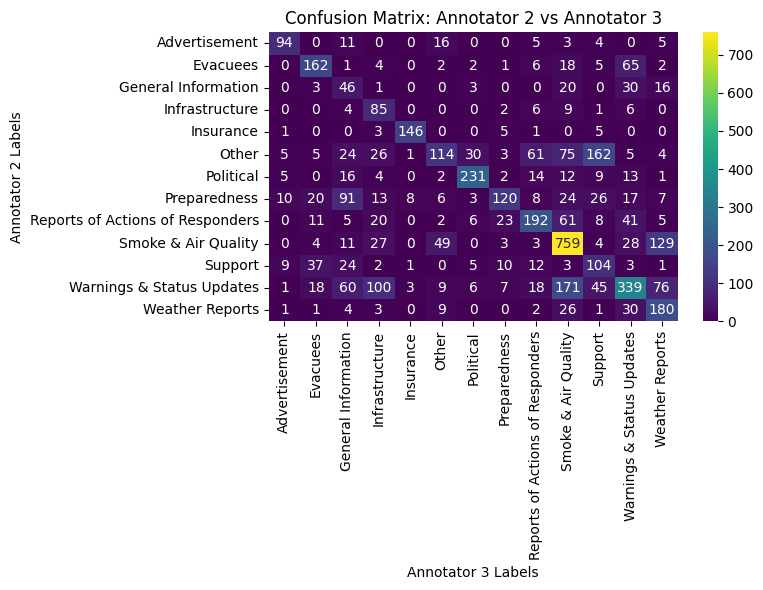

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your annotator labels
annotators = {
    'Annotator 1': labels1,
    'Annotator 2': labels2,
    'Annotator 3': labels3,
}

# Get all unique labels for consistent axes
all_labels = sorted(set(label for rater in annotators.values() for label in rater))

# Function to plot confusion matrix
def plot_cm(true_labels, pred_labels, annotator_pair):
    cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel(f"{annotator_pair[1]} Labels")
    plt.ylabel(f"{annotator_pair[0]} Labels")
    plt.title(f"Confusion Matrix: {annotator_pair[0]} vs {annotator_pair[1]}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Generate and plot confusion matrices for each pair
pairs = [('Annotator 1', 'Annotator 2'),
         ('Annotator 1', 'Annotator 3'),
         ('Annotator 2', 'Annotator 3')]

for a1, a2 in pairs:
    plot_cm(annotators[a1], annotators[a2], (a1, a2))


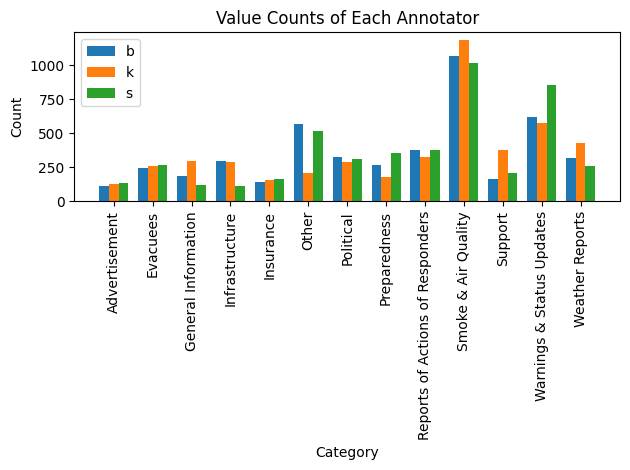

In [ ]:
# check distribution of labels
vc1 = annotator1_labels.value_counts().sort_index()
vc2 = annotator2_labels.value_counts().sort_index()
vc3 = annotator3_labels.value_counts().sort_index()
# Combine all unique categories
all_categories = sorted(set(vc1.index).union(vc2.index).union(vc3.index))
# Reindex all value counts to include all categories
vc1 = vc1.reindex(all_categories, fill_value=0)
vc2 = vc2.reindex(all_categories, fill_value=0)
vc3 = vc3.reindex(all_categories, fill_value=0)
# Plot
x = range(len(all_categories))
width = 0.25
plt.bar([i - width for i in x], vc1.values, width=width, label='b')
plt.bar(x, vc2.values, width=width, label='k')
plt.bar([i + width for i in x], vc3.values, width=width, label='s')
plt.xticks(x, all_categories, rotation=90)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Value Counts of Each Annotator")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
voted_labels = []
for i in range(len(annotator1_labels)):
    #labels = [combined_df.loc[i, 'label'], annotator2_json.loc[i, 'image_classes']]
    #labels = [combined_df.loc[i, 'label'], annotator3_json.loc[i, 'image_classes']]
    #labels = [annotator2_json.loc[i, 'image_classes'], annotator3_json.loc[i, 'image_classes']]
    labels = [combined_df.loc[i, 'label'], annotator2_json.loc[i, 'image_classes'], annotator3_json.loc[i, 'image_classes']]
    most_common = Counter(labels).most_common()
    
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:     # if there is a tie between the 3 labels
        voted = None                                                        # then there is no agreement
    else:
        voted = most_common[0][0]                                           # else pick the label with most votes (some agreement)
    
    voted_labels.append(voted)

In [ ]:
b = voted_labels == combined_df['label']
s = voted_labels == annotator2_json['image_classes']
k = voted_labels == annotator3_json['image_classes']
print(f"Agreement with 1 labels: {b.mean():.2%}")   # 78.65% agreement for the vote between all labels and b
print(f"Agreement with 2 labels: {s.mean():.2%}")   # 77.45% agreement for the vote between all labels and s
print(f"Agreement with 3 labels: {k.mean():.2%}\n") # 65.81% agreement for the vote between all labels and k

Agreement with 1 labels: 78.65%
Agreement with 2 labels: 77.45%
Agreement with 3 labels: 65.81%



In [ ]:
# Majority agreement rate (at least 2 same):   88.40%
# Full agreement rate (all 3 same):            45.12%
# No agreement (all 3 different):              11.60%

# Agreement for the vote between all annotators and b annotator 1: 78.65%
# Agreement for the vote between all annotators and s annotator 2: 77.45%
# Agreement for the vote between all annotators and k annotator 3: 65.81%

# Agreement for the vote between annotators 2-3 and annotator 1: 54.86%
# Agreement for the vote between annotators 1-3 and annotator 2: 56.06%
# Agreement for the vote between annotators 1-2 and annotator 3: 67.70%

# how much two annotators agree on labeling a dataset above what would be expected by chance:
# Cohen's Kappa between annotator 1-2: 0.635
# Cohen's Kappa between annotator 1-3: 0.506
# Cohen's Kappa between annotator 2-3: 0.492

# similar but suitable for >2 annotators
# Fleiss' Kappa: 0.543

In [18]:
columns_to_drop1 = ['media_keys']
combined_df = combined_df.drop(columns=columns_to_drop1)
combined_df = combined_df.rename(columns={'label': 'label1'})
combined_df.insert(loc=8, column='label2', value=khaled_labels)
combined_df.insert(loc=9, column='label3', value=stratos_labels)
combined_df.insert(loc=10, column='voted_label', value=None)

In [ ]:
from collections import Counter
voted_labels = []
for i in range(len(my_labels)):
    labels = [combined_df.loc[i, 'label1'], annotator2_json.loc[i, 'image_classes'], annotator3_json.loc[i, 'image_classes']]
    most_common = Counter(labels).most_common()
    
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:     # if there is a tie between the 3 labels
        voted = labels[0]                                                   # pick label from annotator 1
    else:
        voted = most_common[0][0]                                           # else pick the label with most votes (some agreement)
    
    voted_labels.append(voted)

combined_df['voted_label'] = voted_labels

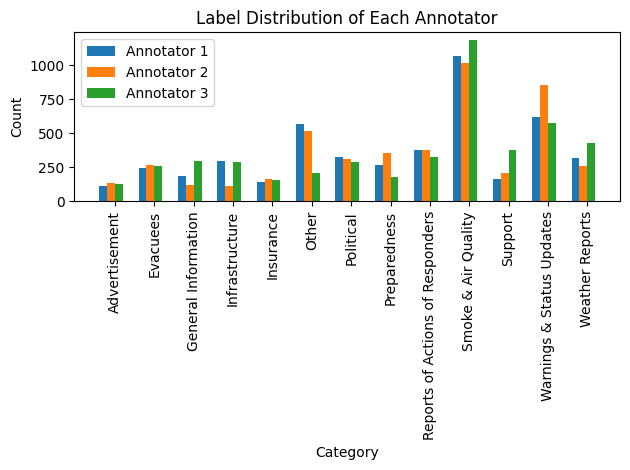

In [ ]:
# check distribution of labels
vc1 = annotator1_labels.value_counts().sort_index()
vc2 = annotator2_labels.value_counts().sort_index()
vc3 = annotator3_labels.value_counts().sort_index()
#vc4 = combined_df['voted_label'].value_counts().sort_index()
# Combine all unique categories
all_categories = sorted(set(vc1.index).union(vc2.index).union(vc3.index))#.union(vc4.index))
# Reindex all value counts to include all categories
vc1 = vc1.reindex(all_categories, fill_value=0)
vc2 = vc2.reindex(all_categories, fill_value=0)
vc3 = vc3.reindex(all_categories, fill_value=0)
#vc4 = vc4.reindex(all_categories, fill_value=0)
# Plot
x = range(len(all_categories))
width = 0.2  # Adjust width for four bars
plt.bar([i - 1.5*width for i in x], vc1.values, width=width, label='Annotator 1')
plt.bar([i - 0.5*width for i in x], vc2.values, width=width, label='Annotator 2')
plt.bar([i + 0.5*width for i in x], vc3.values, width=width, label='Annotator 3')
#plt.bar([i + 1.5*width for i in x], vc4.values, width=width, label='voted')
plt.xticks(x, all_categories, rotation=90)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Label Distribution of Each Annotator")
plt.legend()
plt.tight_layout()
plt.show()

In [167]:
combined_df.to_csv('dataset.csv', index=False)

In [23]:
combined_df['voted_label'].value_counts()

voted_label
Smoke & Air Quality                 1128
Warnings & Status Updates            669
Other                                507
Reports of Actions of Responders     356
Political                            329
Weather Reports                      296
Preparedness                         264
Infrastructure                       264
Evacuees                             252
Support                              178
General Information                  170
Insurance                            158
Advertisement                        117
Name: count, dtype: int64